## Configure PySpark Setup

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.0.1/spark-3.0.1-bin-hadoop2.7.tgz
!tar xf spark-3.0.1-bin-hadoop2.7.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop2.7"


import findspark
findspark.init()


import pyspark 
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("App").getOrCreate()
spark

In [2]:
# check number of cores PySpark is using
cores = spark._jsc.sc().getExecutorMemoryStatus().keySet().size()
print("You are working with", cores, "core(s)")

You are working with 1 core(s)


In [3]:
!cp /content/drive/MyDrive/Datasets.zip .
!unzip Datasets.zip

Archive:  Datasets.zip
   creating: Datasets/
  inflating: Datasets/fifa19.csv     
  inflating: Datasets/.DS_Store      
  inflating: Datasets/zomato.csv     
  inflating: Datasets/nyc_air_bnb.csv  
  inflating: Datasets/supermarket_sales.csv  
  inflating: Datasets/users3.parquet  
  inflating: Datasets/Toddler Autism dataset July 2018.csv  
   creating: Datasets/uw-madison-courses/
  inflating: Datasets/uw-madison-courses/course_offerings.csv  
  inflating: Datasets/uw-madison-courses/sections.csv  
  inflating: Datasets/uw-madison-courses/schedules.csv  
  inflating: Datasets/uw-madison-courses/database.sqlite3  
  inflating: Datasets/uw-madison-courses/rooms.csv  
  inflating: Datasets/uw-madison-courses/teachings.csv  
  inflating: Datasets/uw-madison-courses/subjects.csv  
  inflating: Datasets/uw-madison-courses/subject_memberships.csv  
  inflating: Datasets/uw-madison-courses/grade_distributions.csv  
  inflating: Datasets/uw-madison-courses/instructors.csv  
  inflating: Dat

# Load Libraries

In [4]:
from pyspark.ml.feature import VectorAssembler,StandardScaler
from pyspark.sql.types import * 

from pyspark.ml.evaluation import *
from pyspark.sql.functions import *

from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.clustering import GaussianMixture


import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# ML Model Building

In [5]:
path ="Datasets/"
df = spark.read.csv(path+'credit_card_data.csv',inferSchema=True,header=True)

In [6]:
df.limit(5).toPandas()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [7]:
df.printSchema()

root
 |-- CUST_ID: string (nullable = true)
 |-- BALANCE: double (nullable = true)
 |-- BALANCE_FREQUENCY: double (nullable = true)
 |-- PURCHASES: double (nullable = true)
 |-- ONEOFF_PURCHASES: double (nullable = true)
 |-- INSTALLMENTS_PURCHASES: double (nullable = true)
 |-- CASH_ADVANCE: double (nullable = true)
 |-- PURCHASES_FREQUENCY: double (nullable = true)
 |-- ONEOFF_PURCHASES_FREQUENCY: double (nullable = true)
 |-- PURCHASES_INSTALLMENTS_FREQUENCY: double (nullable = true)
 |-- CASH_ADVANCE_FREQUENCY: double (nullable = true)
 |-- CASH_ADVANCE_TRX: integer (nullable = true)
 |-- PURCHASES_TRX: integer (nullable = true)
 |-- CREDIT_LIMIT: double (nullable = true)
 |-- PAYMENTS: double (nullable = true)
 |-- MINIMUM_PAYMENTS: double (nullable = true)
 |-- PRC_FULL_PAYMENT: double (nullable = true)
 |-- TENURE: integer (nullable = true)



In [8]:
# fill missing values
def fill_with_mean(df, include=set()): 
    stats = df.agg(*(avg(c).alias(c) for c in df.columns if c in include))
    return df.na.fill(stats.first().asDict())

columns = df.columns

# exlcuding first column as it id
columns = columns[1:]

df = fill_with_mean(df, columns)
df.limit(5).toPandas()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,864.206542,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [9]:
df.count()

8950

In [10]:
# vectorized input features

input_columns = df.columns 
input_columns = input_columns[1:] 
vecAssembler = VectorAssembler(inputCols=input_columns, outputCol="raw_features")
df_kmeans = vecAssembler.transform(df)
df_kmeans.limit(4).toPandas()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,raw_features
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12,"[40.900749, 0.818182, 95.4, 0.0, 95.4, 0.0, 0...."
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12,"(3202.467416, 0.909091, 0.0, 0.0, 0.0, 6442.94..."
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12,"[2495.148862, 1.0, 773.17, 773.17, 0.0, 0.0, 1..."
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,864.206542,0.000000,12,"[1666.670542, 0.636364, 1499.0, 1499.0, 0.0, 2..."


In [11]:
# scaling the vectors
scaler = StandardScaler(inputCol="raw_features", outputCol="features" )
df_kmeans = scaler.fit(df_kmeans).transform(df_kmeans)
df_kmeans.limit(4).toPandas()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,raw_features,features
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12,"[40.900749, 0.818182, 95.4, 0.0, 95.4, 0.0, 0....","[0.019649350271146598, 3.453643630870587, 0.04..."
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12,"(3202.467416, 0.909091, 0.0, 0.0, 0.0, 6442.94...","(1.5385147100586776, 3.8373813430652013, 0.0, ..."
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12,"[2495.148862, 1.0, 773.17, 773.17, 0.0, 0.0, 1...","[1.198707973980888, 4.221119055259816, 0.36186..."
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,864.206542,0.000000,12,"[1666.670542, 0.636364, 1499.0, 1499.0, 0.0, 2...","[0.8006942187381397, 2.6861682064813577, 0.701..."


## K Means Clustering

In [12]:
kmax = 10
evaluator = ClusteringEvaluator()

score = []

for k in range(2,kmax):
    
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model = kmeans.fit(df_kmeans)
    predictions = model.transform(df_kmeans)
    
    #computing Silhouette score
    cost = evaluator.evaluate(predictions)
    score.append(cost)

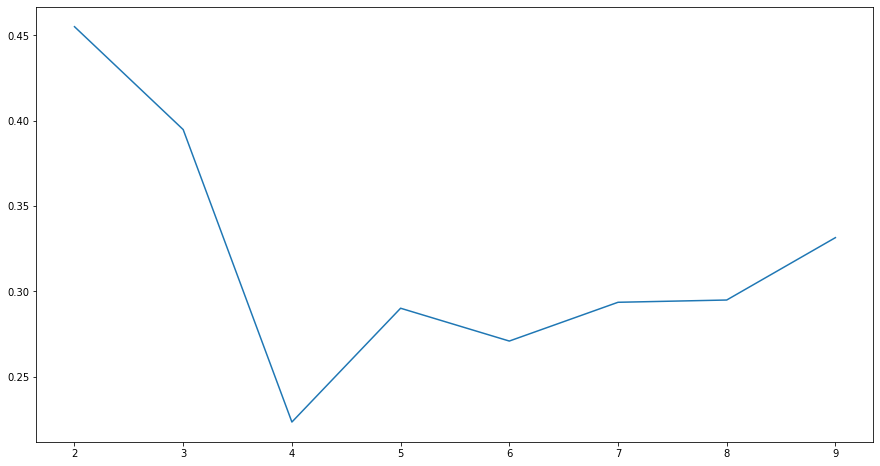

In [13]:
plt.figure(figsize=(15,8))
plt.plot(range(2,kmax),score)

In [14]:
# select k and run clustering
k = 3
kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
model = kmeans.fit(df_kmeans)
predictions = model.transform(df_kmeans)
predictions.limit(3).toPandas()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,raw_features,features,prediction
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.0,0.083333,0.00,0,2,1000.0,201.802084,139.509787,0.000000,12,"[40.900749, 0.818182, 95.4, 0.0, 95.4, 0.0, 0....","[0.019649350271146598, 3.453643630870587, 0.04...",1
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.0,0.000000,0.25,4,0,7000.0,4103.032597,1072.340217,0.222222,12,"(3202.467416, 0.909091, 0.0, 0.0, 0.0, 6442.94...","(1.5385147100586776, 3.8373813430652013, 0.0, ...",2
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.0,0.000000,0.00,0,12,7500.0,622.066742,627.284787,0.000000,12,"[2495.148862, 1.0, 773.17, 773.17, 0.0, 0.0, 1...","[1.198707973980888, 4.221119055259816, 0.36186...",1


In [15]:
predictions.groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1| 6107|
|         2| 1570|
|         0| 1273|
+----------+-----+



In [16]:
# Shows the cluster centers
centers = model.clusterCenters()
centers

[array([1.04915345, 4.14381927, 1.9600552 , 1.60618447, 1.68333817,
        0.21462613, 2.36224146, 2.2300431 , 1.86043443, 0.31213208,
        0.22105675, 2.24183889, 2.10148985, 1.40806352, 0.52803533,
        1.02200264, 8.9042244 ]),
 array([0.38788749, 3.52295761, 0.23250972, 0.14898513, 0.27623634,
        0.16044417, 1.14794402, 0.43291548, 0.86173866, 0.34600201,
        0.18034736, 0.34141036, 0.8977647 , 0.31368132, 0.23999871,
        0.5273668 , 8.57597575]),
 array([1.92761603, 4.04687338, 0.1817118 , 0.15185185, 0.15068879,
        1.86592866, 0.58190051, 0.37518784, 0.36508838, 2.25440462,
        1.83613179, 0.22622752, 1.84644827, 1.05156891, 0.75295787,
        0.11467982, 8.47906855])]

In [17]:
d = {col:'mean' for col in input_columns}
d

{'BALANCE': 'mean',
 'BALANCE_FREQUENCY': 'mean',
 'CASH_ADVANCE': 'mean',
 'CASH_ADVANCE_FREQUENCY': 'mean',
 'CASH_ADVANCE_TRX': 'mean',
 'CREDIT_LIMIT': 'mean',
 'INSTALLMENTS_PURCHASES': 'mean',
 'MINIMUM_PAYMENTS': 'mean',
 'ONEOFF_PURCHASES': 'mean',
 'ONEOFF_PURCHASES_FREQUENCY': 'mean',
 'PAYMENTS': 'mean',
 'PRC_FULL_PAYMENT': 'mean',
 'PURCHASES': 'mean',
 'PURCHASES_FREQUENCY': 'mean',
 'PURCHASES_INSTALLMENTS_FREQUENCY': 'mean',
 'PURCHASES_TRX': 'mean',
 'TENURE': 'mean'}

In [18]:
predictions.groupBy('prediction').agg(d).show()

+----------+------------------+-------------------------------+------------------+------------------+---------------------------+---------------------+----------------------+---------------------+------------------------+------------------+---------------------------+-------------------------------------+---------------------+------------------+-----------------+------------------+---------------------+
|prediction|      avg(BALANCE)|avg(ONEOFF_PURCHASES_FREQUENCY)|avg(PURCHASES_TRX)|     avg(PAYMENTS)|avg(INSTALLMENTS_PURCHASES)|avg(ONEOFF_PURCHASES)|avg(BALANCE_FREQUENCY)|avg(CASH_ADVANCE_TRX)|avg(PURCHASES_FREQUENCY)| avg(CREDIT_LIMIT)|avg(CASH_ADVANCE_FREQUENCY)|avg(PURCHASES_INSTALLMENTS_FREQUENCY)|avg(MINIMUM_PAYMENTS)|       avg(TENURE)|   avg(PURCHASES)| avg(CASH_ADVANCE)|avg(PRC_FULL_PAYMENT)|
+----------+------------------+-------------------------------+------------------+------------------+---------------------------+---------------------+----------------------+------------

## Bisecting K Means (Similar to Hierarchial Clustering)

In [19]:
kmax = 10
evaluator = ClusteringEvaluator()

score = []

for k in range(2,kmax):
    
    kmeans = BisectingKMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model = kmeans.fit(df_kmeans)
    predictions = model.transform(df_kmeans)
    
    #computing Silhouette score
    cost = evaluator.evaluate(predictions)
    score.append(cost)

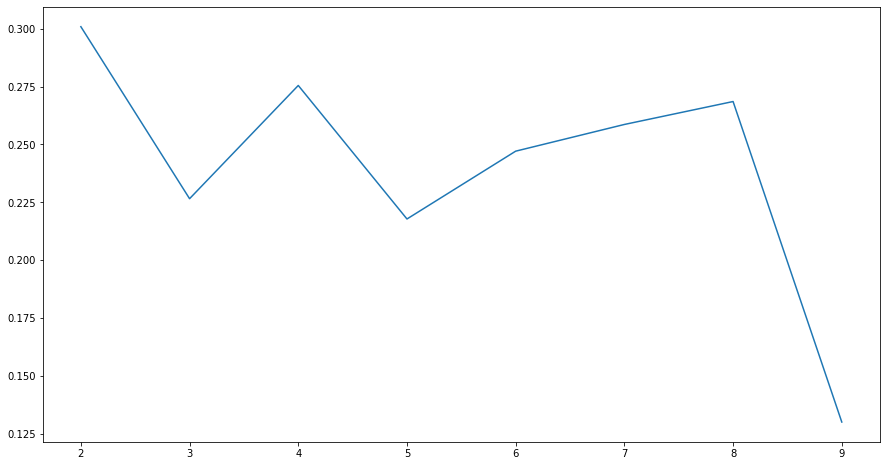

In [20]:
plt.figure(figsize=(15,8))
plt.plot(range(2,kmax),score)

## Gaussian Mixture Clustering

In [21]:
kmax = 11
log_likli = []
for k in range(2,kmax):
    gm = GaussianMixture(k=k, tol=0.0001,maxIter=10, seed=10,featuresCol='features')
    model = gm.fit(df_kmeans)
    summary = model.summary
    log_likli.append(summary.logLikelihood)

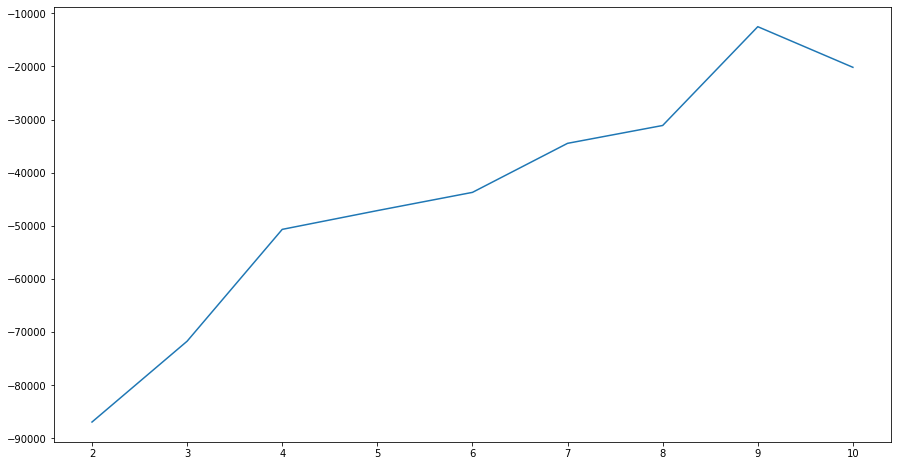

In [22]:
# select cluster which maximize log likelihood
plt.figure(figsize=(15,8))
plt.plot(range(2,kmax),log_likli)

In [23]:
#for the sake of speed and simplicity we will stick with k = 5
gm = GaussianMixture(k=5, maxIter=10, seed=10)
model = gm.fit(df_kmeans)

summary = model.summary

print("Clusters: ",summary.k)
print("Cluster Sizes: ",summary.clusterSizes)
print("Log Likelihood: ",summary.logLikelihood)

weights = model.weights
print("Model Weights: :",len(weights))

print("Means: ", model.gaussiansDF.select("mean").head())

print("Cov: ",model.gaussiansDF.select("cov").head())

transformed = model.transform(df_kmeans)

Clusters:  5
Cluster Sizes:  [743, 2904, 2440, 2455, 408]
Log Likelihood:  -47124.07780724605
Model Weights: : 5
Means:  Row(mean=DenseVector([2.0978, 4.1702, 1.2006, 0.9011, 1.1836, 1.0001, 2.0017, 1.3146, 1.6417, 1.4668, 1.1356, 1.5679, 2.0397, 1.1868, 1.3739, 0.0962, 8.6514]))
Cov:  Row(cov=DenseMatrix(17, 17, [2.2266, 0.0589, 0.3885, 0.3227, 0.3244, 0.406, -0.0053, -0.0344, ..., -0.0861, 0.0274, 0.2308, 0.1819, 0.2186, 0.2634, 0.0018, 0.7334], False))


In [24]:
transformed.limit(3).toPandas()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,raw_features,features,probability,prediction
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.0,0.083333,0.00,0,2,1000.0,201.802084,139.509787,0.000000,12,"[40.900749, 0.818182, 95.4, 0.0, 95.4, 0.0, 0....","[0.019649350271146598, 3.453643630870587, 0.04...","[4.5916870778173473e-10, 0.9999997860039278, 6...",1
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.0,0.000000,0.25,4,0,7000.0,4103.032597,1072.340217,0.222222,12,"(3202.467416, 0.909091, 0.0, 0.0, 0.0, 6442.94...","(1.5385147100586776, 3.8373813430652013, 0.0, ...","[7.911704755239962e-05, 0.00010615069395605155...",4
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.0,0.000000,0.00,0,12,7500.0,622.066742,627.284787,0.000000,12,"[2495.148862, 1.0, 773.17, 773.17, 0.0, 0.0, 1...","[1.198707973980888, 4.221119055259816, 0.36186...","[5.885467283525961e-08, 2.866055530771904e-14,...",3
